In [9]:
import os
import sys

if "COLAB_GPU" in os.environ:
  from google.colab import drive
  print("Hello, Colab")
  drive.mount("/content/drive")
  ROOT_PATH = "/content/drive/MyDrive/hero"
  os.environ["CLEARML_CONFIG_FILE"] = f"{ROOT_PATH}/clearml.conf"
elif "PAPERSPACE_CLUSTER_ID" in os.environ:
  print("Hello, Paperspace")
  ROOT_PATH = "/notebooks/hero"
  os.environ["CLEARML_CONFIG_FILE"] = f"{ROOT_PATH}/clearml.conf"
else:
  print("Hello, Local PC")
  ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))

BTCNN_PATH = os.path.join(ROOT_PATH, "btcnn")
HBO_BENCH_PATH = os.path.join(ROOT_PATH, "hbo_bench")

sys.path.insert(0, ROOT_PATH)
sys.path.insert(0, BTCNN_PATH)
sys.path.insert(0, HBO_BENCH_PATH)

EXPERIMENT_PATH = f"{ROOT_PATH}/experiments/emulation"
ARTIFACTS_PATH = f"{EXPERIMENT_PATH}/artifacts"

Hello, Local PC


In [2]:
import random
from collections import defaultdict
from matplotlib import pyplot as plt
from json import dump, load

import torch
import pandas as pd
import numpy as np

from hero import Hero
from wrappers import ORACLES_DICT, initialize_oracles, _get_e2e_time, _get_execution_time, _get_planning_time, _get_logical_tree
from neural_network import NN
from hbo_bench.local_search_settings import *
from neural_network import get_bt_regressor
from train_utils import load_model
from emulation import get_report, emulate_online_learning
from hbo_bench.data_config import DEFAULT_DOP, DEFAULT_HINTSET

In [3]:
initialize_oracles(HBO_BENCH_PATH, ["JOB", "sample_queries"])

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {DEVICE}")

device is cpu


In [5]:
job_workload = ORACLES_DICT["JOB"].get_query_names()
sq_workload = ORACLES_DICT["sample_queries"].get_query_names()

# Static Workload

## Ideal Case (all plans are in train data)

### Default Dop

In [11]:
job_ideal_model = NN(
    fit_settings=ALL_SS, 
    inference_settings=EMPTY_SS, 
    model=get_bt_regressor("job_ideal_model", DEVICE),
    path_to_save=f"{EXPERIMENT_PATH}/models/job_ideal_model.pth"
)
job_ideal_model.fit(job_workload, epochs=1)
job_ideal_model = load_model(DEVICE, f"{EXPERIMENT_PATH}/models/job_ideal_model.pth", get_bt_regressor("none", DEVICE))

sq_ideal_model = NN(
    fit_settings=ALL_SS, 
    inference_settings=EMPTY_SS, 
    model=get_bt_regressor("sq_ideal_model", DEVICE),
    path_to_save=f"{EXPERIMENT_PATH}/models/sq_ideal_model.pth"
)
sq_ideal_model.fit(sq_workload, epochs=1)
sq_ideal_model = load_model(DEVICE, f"{EXPERIMENT_PATH}/models/sq_ideal_model.pth", get_bt_regressor("none", DEVICE))

[1/1] MSE: 3328.7241: 100%|██████████| 1/1 [00:10<00:00, 10.31s/it]


In [12]:
def extend_df(df):
    df["ex boost (% of opt)"] = 100 * (df["def_ex"] - df["custom_ex"]) / (df["def_ex"] - df["opt_ex"])
    df["e2e boost (% of opt)"] = 100 * (df["def_e2e"] - df["custom_e2e"]) / (df["def_e2e"] - df["opt_e2e"])
    df["e2e boost (%)"] = 100 * (df["def_e2e"] - df["custom_e2e"]) / df["def_e2e"]
    
    columns = [
        "model", 
        "searching_settings", 
        "workload", 
        "e2e boost (%)", 
        "e2e boost (% of opt)", 
        "ex boost (% of opt)", 
        "n_timeouts (%)", 
        "n_real_degradations (%)",
        "custom_e2e", 
        "custom_ex", 
        "custom_inference", 
        "only_def_dop", 
    ]
    
    def count_real_degradations(predictions):
        return sum(
            _get_e2e_time(q_n, hs, dop, False) > 1.1 * _get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP, False)
            for q_n, hs, dop in predictions
        )
    sizes = df["predictions"].apply(lambda el: len(el))
    df["n_timeouts (%)"] = 100 * df["n_timeouts"].apply(lambda el: int(el)) / sizes
    df["n_real_degradations (%)"] = 100 * df["predictions"].apply(count_real_degradations) / sizes
    df = df[columns]
    return df.round(1)

In [13]:
ss_and_descrs = [
    (GREEDY_DEF_DOP_SS, "greedy"), 
    (PRUNED_GREEDY_DEF_DOP_SS, "pruned greedy"), 
    (LOCAL_DEF_DOP_SS, "local"),
    (PRUNED_LOCAL_DEF_DOP_SS, "pruned local"),
    (ALL_DEF_DOP_SS, "exhaustive")
]

def_dop_ideal_reports = []
for ss, ss_descr in ss_and_descrs:
    ideal_job_nn_model = NN(fit_settings=EMPTY_SS, inference_settings=ss, model=get_bt_regressor("ideal_job", DEVICE))
    ideal_job_nn_model.model = load_model(device=DEVICE, path=f"{EXPERIMENT_PATH}/models/job_ideal_model.pth", model=ideal_job_nn_model.model)
    def_dop_ideal_reports.append(get_report(ideal_job_nn_model, "NN", job_workload, "JOB", ss, ss_descr, only_def_dop=True))

    ideal_job_hero_model = Hero(fit_settings=ss)
    ideal_job_hero_model.fit(job_workload)
    def_dop_ideal_reports.append(get_report(ideal_job_hero_model, "Hero", job_workload, "JOB", ss, ss_descr, only_def_dop=True))
    
    ideal_sq_nn_model = NN(fit_settings=EMPTY_SS, inference_settings=ss, model=get_bt_regressor("ideal_sq", DEVICE))
    ideal_sq_nn_model.model = load_model(device=DEVICE, path=f"{EXPERIMENT_PATH}/models/sq_ideal_model.pth", model=ideal_sq_nn_model.model)
    def_dop_ideal_reports.append(get_report(ideal_sq_nn_model, "NN", sq_workload, "SQ", ss, ss_descr, only_def_dop=True))

    ideal_sq_hero_model = Hero(fit_settings=ss)
    ideal_sq_hero_model.fit(sq_workload)
    def_dop_ideal_reports.append(get_report(ideal_sq_hero_model, "Hero", sq_workload, "SQ", ss, ss_descr, only_def_dop=True))

with open(f"{ARTIFACTS_PATH}/def_dop_ideal_reports.json", "w") as f:
    dump(def_dop_ideal_reports, f)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zinchse/GitHub/hero_paper/experiments/emulation/artifacts/def_dop_ideal_reports.json'

In [16]:
with open(f"{ARTIFACTS_PATH}/def_dop_ideal_reports.json", "r") as f:
    def_dop_df = extend_df(pd.DataFrame(load(f)))

In [17]:
def_dop_df[(def_dop_df["workload"] == "JOB")].sort_values(by="e2e boost (% of opt)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
9,Hero,local,JOB,46.8,97.0,96.4,0.0,0.0,291.1,266.8,24.2,True
1,Hero,greedy,JOB,45.3,94.0,91.4,0.0,0.0,298.9,276.6,22.3,True
13,Hero,pruned local,JOB,38.4,79.6,89.0,0.0,0.0,336.9,281.3,55.6,True
5,Hero,pruned greedy,JOB,28.5,59.2,61.3,0.0,0.0,390.6,335.4,55.3,True
12,NN,pruned local,JOB,8.0,16.6,39.9,9.7,15.0,503.0,377.2,125.8,True
4,NN,pruned greedy,JOB,1.3,2.7,15.5,0.0,6.2,539.6,424.9,114.7,True
17,Hero,exhaustive,JOB,0.0,0.0,0.0,0.0,0.0,546.7,455.3,91.4,True
0,NN,greedy,JOB,-53.4,-110.8,-57.0,14.2,23.9,838.8,566.8,272.0,True
8,NN,local,JOB,-63.5,-131.7,-71.5,22.1,32.7,893.7,595.0,298.7,True
16,NN,exhaustive,JOB,-66.0,-137.0,-120.0,39.8,52.2,907.7,690.0,217.8,True


In [18]:
def_dop_df[(def_dop_df["workload"] == "SQ")].sort_values(by="e2e boost (% of opt)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
11,Hero,local,SQ,64.5,93.9,96.1,0.0,0.0,273.2,240.1,33.1,True
3,Hero,greedy,SQ,63.2,92.0,93.2,0.0,0.0,283.6,254.2,29.4,True
15,Hero,pruned local,SQ,58.3,84.9,89.3,0.0,0.0,320.7,273.4,47.3,True
7,Hero,pruned greedy,SQ,53.0,77.1,80.1,0.0,0.0,361.9,318.3,43.6,True
6,NN,pruned greedy,SQ,5.5,8.0,11.7,5.0,30.0,727.1,654.1,73.0,True
19,Hero,exhaustive,SQ,0.0,0.0,0.0,0.0,0.0,769.7,711.5,58.2,True
14,NN,pruned local,SQ,-14.5,-21.1,-15.9,27.5,57.5,881.2,789.4,91.8,True
2,NN,greedy,SQ,-32.5,-47.4,-16.3,37.5,52.5,1020.1,791.6,228.5,True
10,NN,local,SQ,-47.3,-68.9,-31.6,57.5,70.0,1133.6,866.5,267.1,True
18,NN,exhaustive,SQ,-62.6,-91.1,-81.2,70.0,80.0,1251.4,1110.1,141.3,True


### All Dop's

In [19]:
ss_and_descrs = [
    (GREEDY_SS, "greedy"), 
    (PRUNED_GREEDY_SS, "pruned greedy"), 
    (LOCAL_SS, "local"),
    (PRUNED_LOCAL_SS, "pruned local"),
    (ALL_SS, "exhaustive")
]

all_dops_ideal_reports = []
for ss, ss_descr in ss_and_descrs:
    ideal_job_nn_model = NN(fit_settings=EMPTY_SS, inference_settings=ss, model=get_bt_regressor("ideal_job", DEVICE))
    ideal_job_nn_model.model = load_model(device=DEVICE, path=f"{EXPERIMENT_PATH}/models/job_ideal_model.pth", model=ideal_job_nn_model.model)
    all_dops_ideal_reports.append(get_report(ideal_job_nn_model, "NN", job_workload, "JOB", ss, ss_descr, only_def_dop=False))

    ideal_job_hero_model = Hero(fit_settings=ss)
    ideal_job_hero_model.fit(job_workload)
    all_dops_ideal_reports.append(get_report(ideal_job_hero_model, "Hero", job_workload, "JOB", ss, ss_descr, only_def_dop=False))
    
    ideal_sq_nn_model = NN(fit_settings=EMPTY_SS, inference_settings=ss, model=get_bt_regressor("ideal_sq", DEVICE))
    ideal_sq_nn_model.model = load_model(device=DEVICE, path=f"{EXPERIMENT_PATH}/models/sq_ideal_model.pth", model=ideal_sq_nn_model.model)
    all_dops_ideal_reports.append(get_report(ideal_sq_nn_model, "NN", sq_workload, "SQ", ss, ss_descr, only_def_dop=False))

    ideal_sq_hero_model = Hero(fit_settings=ss)
    ideal_sq_hero_model.fit(sq_workload)
    all_dops_ideal_reports.append(get_report(ideal_sq_hero_model, "Hero", sq_workload, "SQ", ss, ss_descr, only_def_dop=False))

with open(f"{ARTIFACTS_PATH}/all_dops_ideal_reports.json", "w") as f:
    dump(all_dops_ideal_reports, f)

/Users/zinchse/GitHub/hero_paper/train_utils.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_state = torch.load(path, map_location=device)


In [20]:
with open(f"{ARTIFACTS_PATH}/all_dops_ideal_reports.json", "r") as f:
    all_dops_df = extend_df(pd.DataFrame(load(f)))

In [21]:
all_dops_df[(all_dops_df["workload"] == "JOB")].sort_values(by="e2e boost (% of opt)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
9,Hero,local,JOB,64.6,98.4,98.9,0.0,0.0,193.4,166.7,26.7,False
13,Hero,pruned local,JOB,61.2,93.3,97.2,0.0,0.0,212.0,171.9,40.1,False
1,Hero,greedy,JOB,51.2,78.0,70.5,0.0,0.0,266.7,249.6,17.2,False
5,Hero,pruned greedy,JOB,33.2,50.5,49.1,0.0,0.9,365.4,312.0,53.5,False
12,NN,pruned local,JOB,11.4,17.4,43.6,14.2,26.5,484.3,328.1,156.2,False
4,NN,pruned greedy,JOB,1.2,1.8,13.3,0.0,7.1,540.3,416.6,123.8,False
17,Hero,exhaustive,JOB,0.0,0.0,0.0,0.0,0.0,546.7,455.3,91.4,False
0,NN,greedy,JOB,-55.5,-84.6,-33.3,19.5,31.0,850.3,552.4,297.9,False
8,NN,local,JOB,-119.7,-182.4,-106.9,52.2,60.2,1201.1,767.1,434.0,False
16,NN,exhaustive,JOB,-125.4,-191.1,-103.5,67.3,70.8,1232.3,757.1,475.2,False


In [22]:
all_dops_df[(all_dops_df["workload"] == "SQ")].sort_values(by="e2e boost (% of opt)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
11,Hero,local,SQ,69.6,94.0,94.8,0.0,0.0,234.0,208.4,25.6,False
15,Hero,pruned local,SQ,66.9,90.4,91.8,0.0,0.0,254.6,224.2,30.3,False
3,Hero,greedy,SQ,65.3,88.2,89.7,0.0,0.0,267.4,235.3,32.1,False
7,Hero,pruned greedy,SQ,54.9,74.2,76.6,0.0,0.0,347.1,305.1,42.0,False
14,NN,pruned local,SQ,7.6,10.3,22.9,45.0,57.5,711.1,590.2,120.9,False
19,Hero,exhaustive,SQ,0.0,0.0,0.0,0.0,0.0,769.7,711.5,58.2,False
6,NN,pruned greedy,SQ,-34.3,-46.4,-46.8,5.0,32.5,1034.0,960.1,73.9,False
2,NN,greedy,SQ,-68.1,-92.0,-65.5,35.0,57.5,1293.8,1059.2,234.6,False
10,NN,local,SQ,-107.4,-145.1,-102.8,90.0,92.5,1596.1,1257.2,338.8,False
18,NN,exhaustive,SQ,-167.8,-226.7,-200.1,92.5,95.0,2061.2,1773.5,287.7,False


We can see that even in the ideal scenario, the NN loses a bit, mainly due to the longer inference time. Moreover, it sometimes leads to degradations and even `T/O` (this probably happens on small queries).

The advantage of a `PRUNED LOCAL` strategy is also evident.

## Online Scenario

Collecting train data during online optimisation.

In [23]:
for workload, workload_name in [(job_workload, "JOB"), (sq_workload, "SQ")]:
    def_dop_list_online_reports = []
    all_dops_list_online_reports = []

    epochs, iterations = 1, 2
    for ss, ss_descr in [
        (GREEDY_DEF_DOP_SS, "GREEDY"),
        (PRUNED_GREEDY_DEF_DOP_SS, "PRUNED GREEDY"),
        (LOCAL_DEF_DOP_SS, "LOCAL"),
        (PRUNED_LOCAL_DEF_DOP_SS, "PRUNED LOCAL"),
        (ALL_DEF_DOP_SS, "EXHAUSTIVE"),
    ]:
        def_dop_list_online_reports.append(emulate_online_learning("NN", workload, workload_name, ss, ss_descr, True, True, epochs, iterations, None, DEVICE))

    for ss, ss_descr in [
        (GREEDY_SS, "GREEDY"),
        (PRUNED_GREEDY_SS, "PRUNED GREEDY"),
        (LOCAL_SS, "LOCAL"),
        (PRUNED_LOCAL_SS, "PRUNED LOCAL"),
        (ALL_SS, "EXHAUSTIVE"),
    ]:          
        all_dops_list_online_reports.append(emulate_online_learning("NN", workload, workload_name, ss, ss_descr, False, True, epochs, iterations, None, DEVICE))
    
    with open(f"{ARTIFACTS_PATH}/{workload_name}_def_dop_list_online_reports.json", "w") as f:
        dump(def_dop_list_online_reports, f)
    with open(f"{ARTIFACTS_PATH}/{workload_name}_all_dops_list_online_reports.json", "w") as f:
        dump(all_dops_list_online_reports, f)

[1/1] MSE: 8856.6152: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


In [24]:
def visualise(list_reports, title):
    fig, ax = plt.subplots(figsize=(16, 10))
    colors = {
        "opt": "green",
        "def": "orange"
    }

    x_values = np.arange(len(list_reports[0]))

    small_line, big_line = 2, 3
    for i, report in enumerate(list_reports):
        color = plt.cm.viridis(i / len(list_reports))
        ax.plot(
            x_values, 
            [el["custom_ex"] for el in report], 
            marker="o", 
            linewidth=small_line, 
            linestyle='--', 
            color=color, 
            label=f'{report[0]["searching_settings"]} Ex'
        )
        ax.plot(
            x_values, 
            [el["custom_e2e"] for el in report], 
            marker="o", 
            linewidth=big_line, 
            markersize=10.0, 
            linestyle='-', 
            color=color, 
            label=f'{report[0]["searching_settings"]} E2E'
        )

    for metric in ["opt", "def"]:
        for key, linewidth, linestyle, alpha in zip(["ex", "e2e"], [small_line, big_line], ["--", "-"], [0.4, 1.0]):
            value = list_reports[0][0][f"{metric}_{key}"]
            plt.plot(
                [0, len(list_reports[0])-1], 
                [value, value], 
                linewidth=linewidth, 
                color=colors[metric], 
                alpha=alpha, 
                linestyle=linestyle, 
                label=f'{metric}_{key}'
            )
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.set_xticks(range(len(list_reports[0])))
    ax.set_ylim(bottom=0)

    plt.xlabel("iteration")
    plt.ylabel("time (sec)")
    plt.title(f"Convergence of online learning on benchmark {title}")
    plt.show()

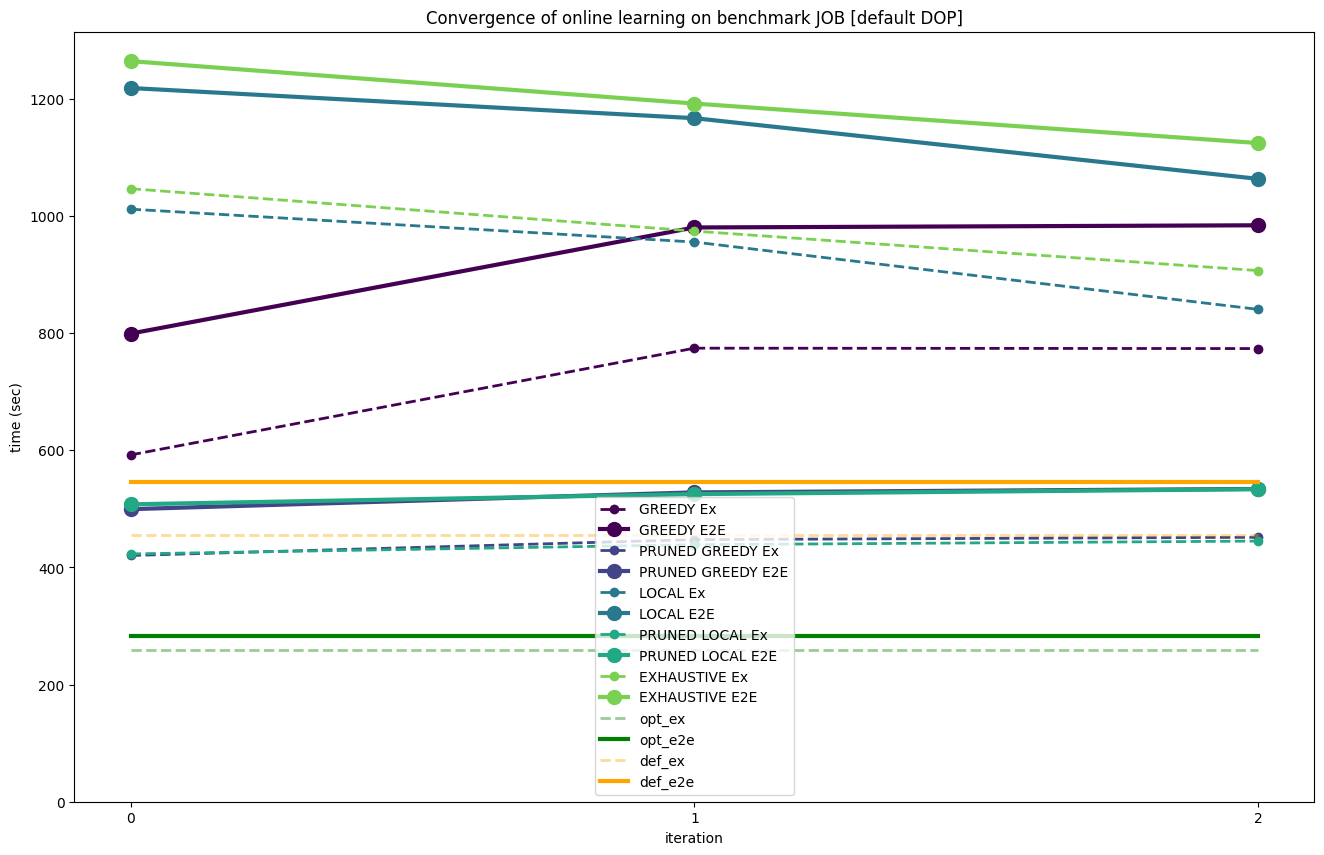

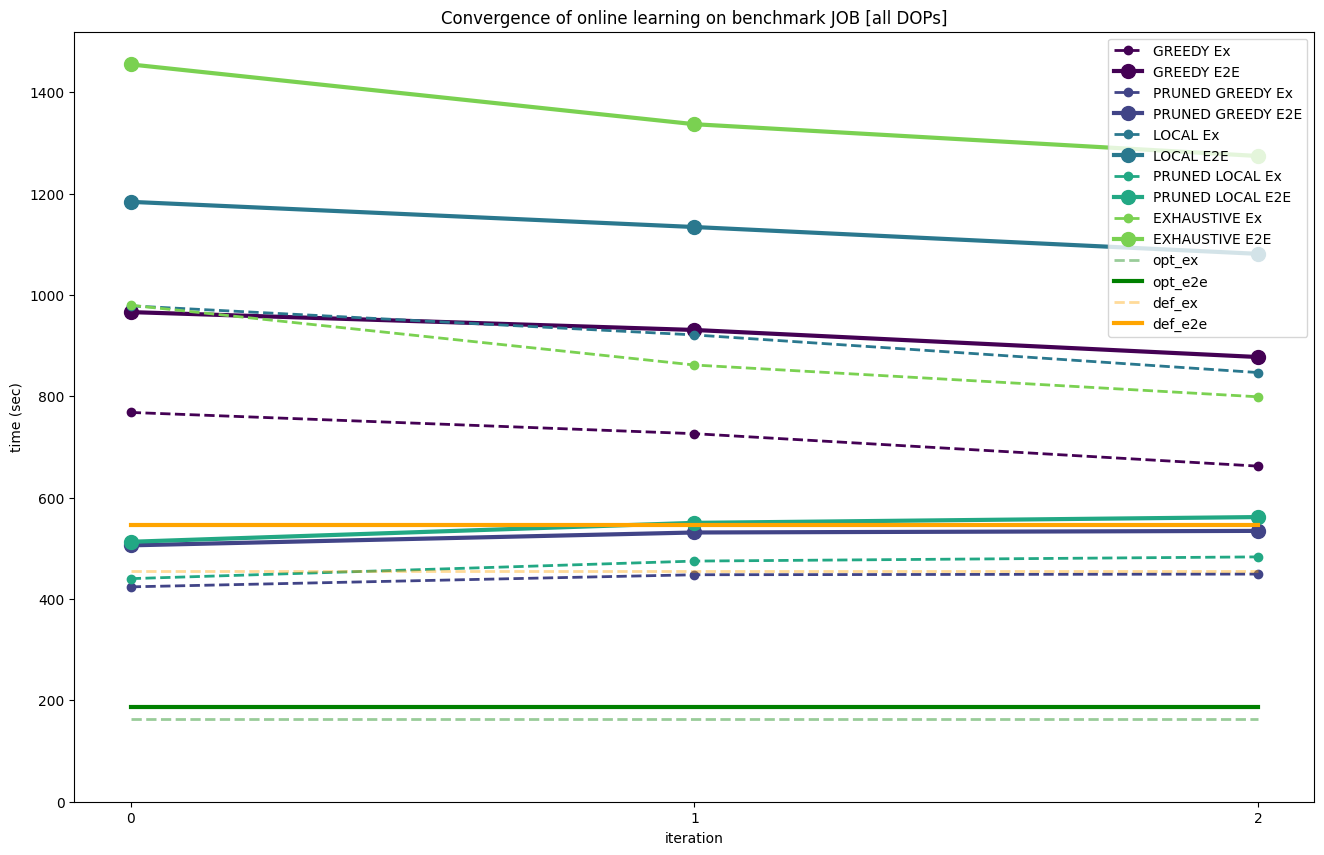

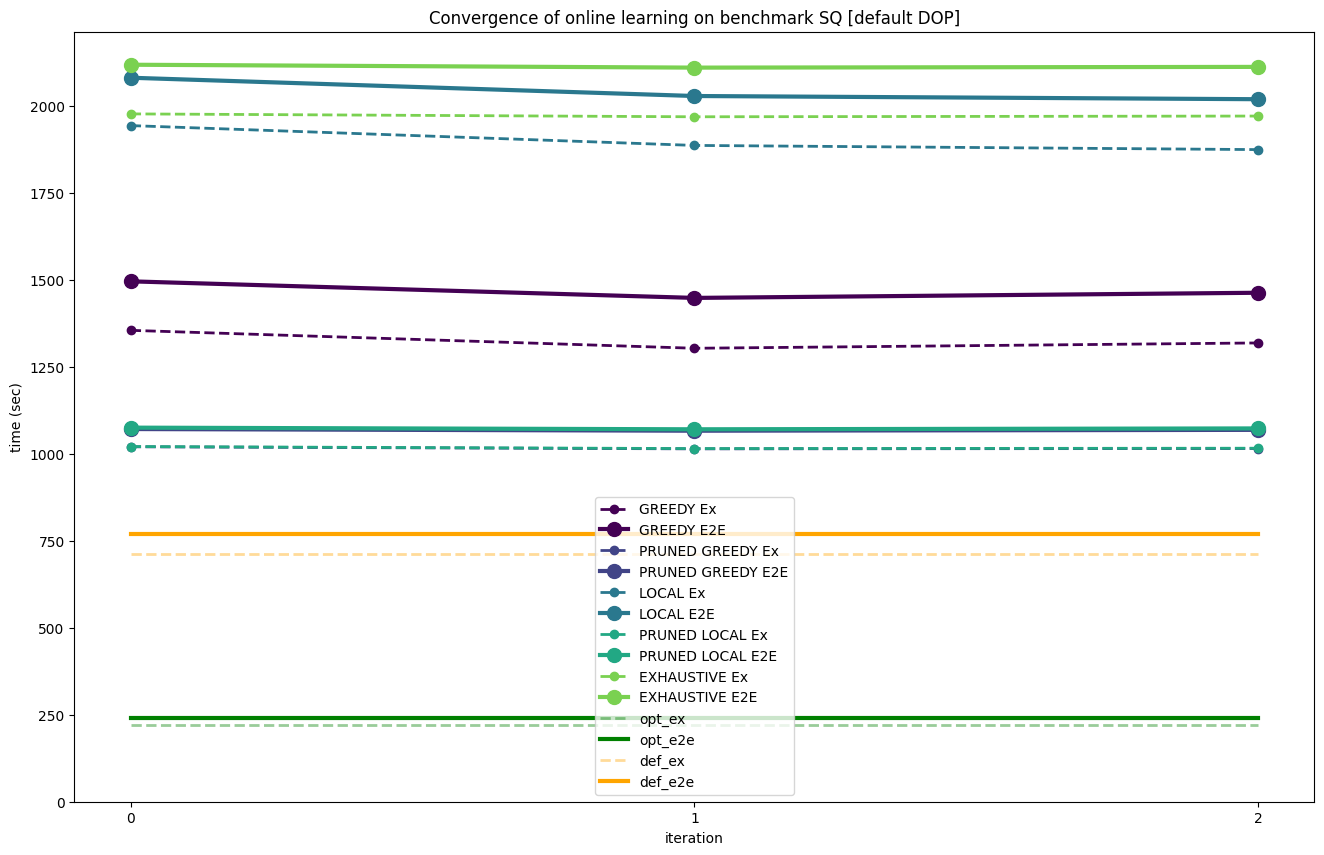

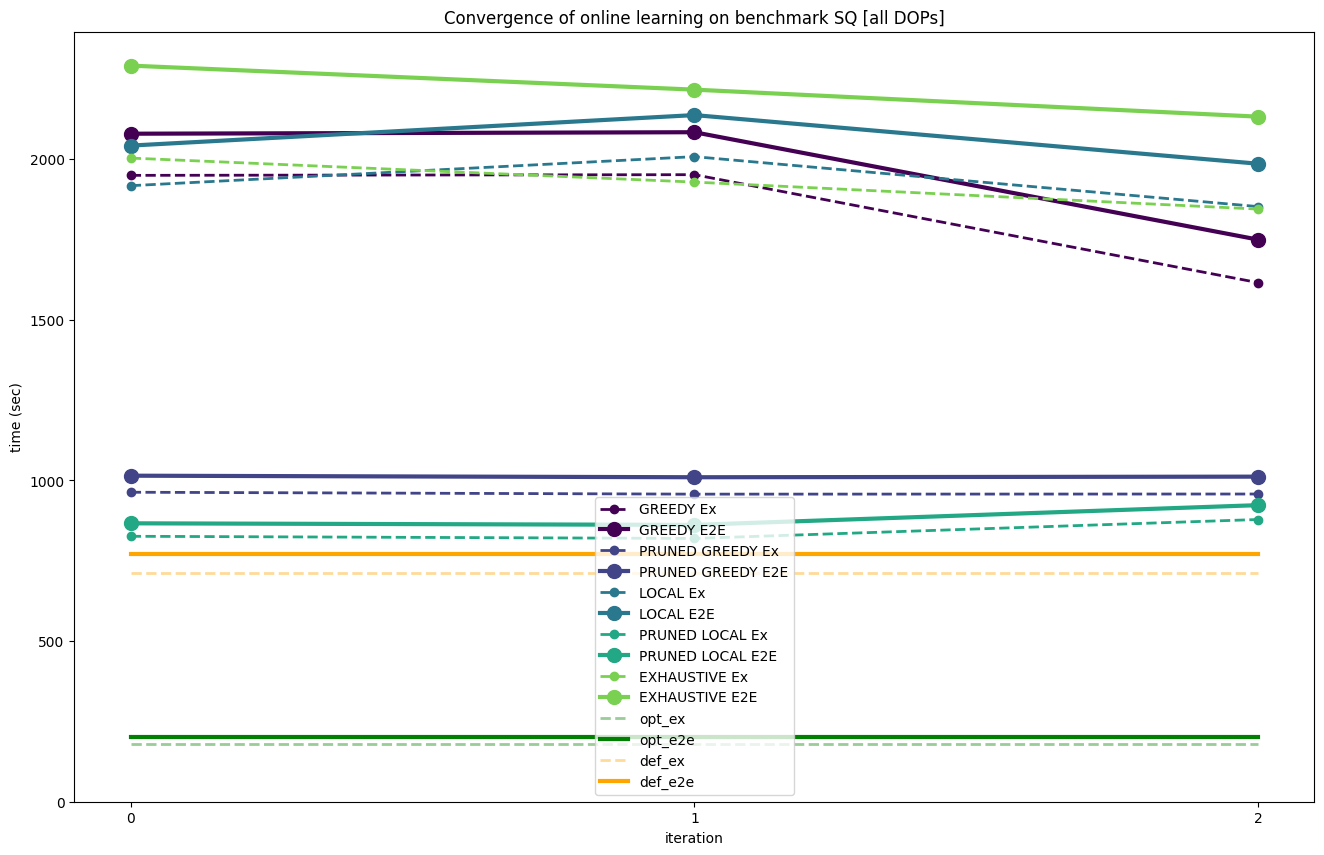

In [25]:
for workload, workload_name in [(job_workload, "JOB"), (sq_workload, "SQ")]:
    with open(f"{ARTIFACTS_PATH}/{workload_name}_def_dop_list_online_reports.json", "r") as f:
        def_dop_list_online_reports = load(f)
        visualise(def_dop_list_online_reports, title=workload_name + " [default DOP]")

    with open(f"{ARTIFACTS_PATH}/{workload_name}_all_dops_list_online_reports.json", "r") as f:
        all_dops_list_online_reports = load(f)
        visualise(all_dops_list_online_reports, title=workload_name + " [all DOPs]")

We see that, as the search space expands, the exhaustive algorithms stop working (at least on JOB). The superiority of the local search algorithm and the pruning procedure is also evident.

Moreover, it did not always converge to the optimum even in 25 iterations - this tells us that it makes sense to take the learning procedure offline (as it is done in `Hero`).

# Dynamic Scenario

## Split by Time

In [26]:
slow_reports, fast_reports = [], []

epochs = 1
for workload, workload_name in [(job_workload, "JOB"), (sq_workload, "SQ")]:
    workload = [q_n for q_n in workload if _get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) > 1]
    print(len(workload))
    slow_time_treshold = np.quantile([_get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) for q_n in workload], .5)
    slow_train = [q_n for q_n in workload if _get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) > slow_time_treshold]
    slow_test = [q_n for q_n in workload if _get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) <= slow_time_treshold]
    assert len(slow_train) + len(slow_test) == len(workload)
    slow_nnmodel = NN(fit_settings=ALL_SS, inference_settings=EMPTY_SS, model=get_bt_regressor("dummy", DEVICE))
    slow_nnmodel.fit(slow_train, epochs)

    fast_time_treshold = np.quantile([_get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) for q_n in workload], .5)
    fast_train = [q_n for q_n in workload if _get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) < fast_time_treshold]
    fast_test = [q_n for q_n in workload if _get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP) >= fast_time_treshold]
    assert len(fast_train) + len(fast_test) == len(workload)
    fast_nnmodel = NN(fit_settings=ALL_SS, inference_settings=EMPTY_SS, model=get_bt_regressor("dummy", DEVICE))
    fast_nnmodel.fit(fast_train, epochs)

    for ss, ss_descr in [
        (GREEDY_SS, "GREEDY"),
        (PRUNED_GREEDY_SS, "PRUNED GREEDY"),
        (LOCAL_SS, "LOCAL"),
        (PRUNED_LOCAL_SS, "PRUNED LOCAL"),
        (ALL_SS, "EXHAUSTIVE"),
    ]:
        slow_reports.append(get_report(slow_nnmodel, "NN", slow_train, f"{workload_name}[train]", ss, ss_descr, only_def_dop=False))
        slow_reports.append(get_report(slow_nnmodel, "NN", slow_test, f"{workload_name}[test]", ss, ss_descr, only_def_dop=False))
        slow_heromodel = Hero(ss)
        slow_heromodel.fit(slow_train)
        slow_reports.append(get_report(slow_heromodel, "Hero", slow_train, f"{workload_name}[train]", ss, ss_descr, only_def_dop=False))
        slow_reports.append(get_report(slow_heromodel, "Hero", slow_test, f"{workload_name}[test]", ss, ss_descr, only_def_dop=False))

        fast_reports.append(get_report(fast_nnmodel, "NN", fast_train, f"{workload_name}[train]", ss, ss_descr, only_def_dop=False))
        fast_reports.append(get_report(fast_nnmodel, "NN", fast_test, f"{workload_name}[test]", ss, ss_descr, only_def_dop=False))
        fast_heromodel = Hero(ss)
        fast_heromodel.fit(fast_train)
        fast_reports.append(get_report(fast_heromodel, "Hero", fast_train, f"{workload_name}[train]", ss, ss_descr, only_def_dop=False))
        fast_reports.append(get_report(fast_heromodel, "Hero", fast_test, f"{workload_name}[test]", ss, ss_descr, only_def_dop=False))

        with open(f"{ARTIFACTS_PATH}/{workload_name}_slow_reports.json", "w") as f:
            dump(slow_reports, f)
        with open(f"{ARTIFACTS_PATH}/{workload_name}_fast_reports.json", "w") as f:
            dump(fast_reports, f)

66


[1/1] MSE: 31.2891: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]


34


[1/1] MSE: 5073.5962: 100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


In [27]:
with open(f"{ARTIFACTS_PATH}/JOB_slow_reports.json", "r") as f:
    job_slow_df = extend_df(pd.DataFrame(load(f)))
with open(f"{ARTIFACTS_PATH}/JOB_fast_reports.json", "r") as f:
    job_fast_df = extend_df(pd.DataFrame(load(f)))
with open(f"{ARTIFACTS_PATH}/SQ_slow_reports.json", "r") as f:
    sq_slow_df = extend_df(pd.DataFrame(load(f)))
with open(f"{ARTIFACTS_PATH}/SQ_fast_reports.json", "r") as f:
    sq_fast_df = extend_df(pd.DataFrame(load(f)))

### slot $\rightarrow$ fast

In [28]:
job_slow_df[(job_slow_df["workload"] == "JOB[train]")].sort_values(by="e2e boost (%)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
10,Hero,LOCAL,JOB[train],63.7,98.5,99.0,0.0,0.0,165.3,146.2,19.1,False
14,Hero,PRUNED LOCAL,JOB[train],61.9,95.6,97.8,0.0,0.0,173.6,149.2,24.4,False
2,Hero,GREEDY,JOB[train],48.6,75.1,69.6,0.0,0.0,234.2,223.7,10.4,False
6,Hero,PRUNED GREEDY,JOB[train],32.1,49.5,48.0,0.0,0.0,309.3,280.9,28.4,False
12,NN,PRUNED LOCAL,JOB[train],15.8,24.4,29.8,18.2,33.3,383.3,328.9,54.4,False
18,Hero,EXHAUSTIVE,JOB[train],0.0,0.0,0.0,0.0,0.0,455.3,407.6,47.7,False
4,NN,PRUNED GREEDY,JOB[train],-1.4,-2.2,1.5,12.1,21.2,461.7,403.6,58.2,False
0,NN,GREEDY,JOB[train],-55.1,-85.2,-59.2,54.5,60.6,706.3,564.0,142.2,False
8,NN,LOCAL,JOB[train],-85.0,-131.4,-103.5,81.8,81.8,842.3,680.8,161.5,False
16,NN,EXHAUSTIVE,JOB[train],-99.9,-154.4,-99.7,81.8,81.8,910.0,670.9,239.1,False


In [29]:
job_slow_df[(job_slow_df["workload"] == "JOB[test]")].sort_values(by="e2e boost (%)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
3,Hero,GREEDY,JOB[test],-0.0,-0.0,0.0,0.0,0.0,73.7,36.4,37.3,False
7,Hero,PRUNED GREEDY,JOB[test],-0.0,-0.0,0.0,0.0,0.0,73.7,36.4,37.3,False
11,Hero,LOCAL,JOB[test],-0.0,-0.0,0.0,0.0,0.0,73.7,36.4,37.3,False
15,Hero,PRUNED LOCAL,JOB[test],-0.0,-0.0,0.0,0.0,0.0,73.7,36.4,37.3,False
19,Hero,EXHAUSTIVE,JOB[test],-0.0,-0.0,0.0,0.0,0.0,73.7,36.4,37.3,False
5,NN,PRUNED GREEDY,JOB[test],-17.1,-22.7,1.9,0.0,12.1,86.2,35.9,50.3,False
13,NN,PRUNED LOCAL,JOB[test],-23.5,-31.2,-3.8,12.1,18.2,91.0,37.3,53.7,False
1,NN,GREEDY,JOB[test],-197.1,-261.3,-262.3,30.3,33.3,218.8,100.1,118.7,False
9,NN,LOCAL,JOB[test],-250.8,-332.5,-285.1,69.7,69.7,258.4,105.6,152.7,False
17,NN,EXHAUSTIVE,JOB[test],-309.7,-410.5,-301.6,84.8,84.8,301.7,109.7,192.1,False


In [30]:
sq_slow_df[(sq_slow_df["workload"] == "SQ[train]")].sort_values(by="e2e boost (%)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
30,Hero,LOCAL,SQ[train],72.2,94.3,94.7,0.0,0.0,179.7,165.2,14.4,False
34,Hero,PRUNED LOCAL,SQ[train],70.5,92.0,92.4,0.0,0.0,191.2,176.2,15.0,False
22,Hero,GREEDY,SQ[train],69.2,90.3,91.0,0.0,0.0,199.3,183.2,16.1,False
26,Hero,PRUNED GREEDY,SQ[train],60.2,78.6,79.9,0.0,0.0,257.5,236.8,20.7,False
32,NN,PRUNED LOCAL,SQ[train],23.1,30.1,31.7,35.3,41.2,498.0,469.4,28.6,False
24,NN,PRUNED GREEDY,SQ[train],2.3,3.0,3.9,5.9,23.5,632.6,603.2,29.5,False
38,Hero,EXHAUSTIVE,SQ[train],0.0,0.0,0.0,0.0,0.0,647.4,622.0,25.3,False
20,NN,GREEDY,SQ[train],-86.6,-113.0,-106.3,82.4,88.2,1207.9,1134.9,73.1,False
28,NN,LOCAL,SQ[train],-93.6,-122.2,-112.6,94.1,94.1,1253.4,1164.9,88.6,False
36,NN,EXHAUSTIVE,SQ[train],-106.6,-139.2,-121.2,100.0,100.0,1337.6,1206.4,131.2,False


In [31]:
sq_slow_df[(sq_slow_df["workload"] == "SQ[test]")].sort_values(by="e2e boost (%)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
23,Hero,GREEDY,SQ[test],0.0,0.0,0.0,0.0,0.0,120.3,88.1,32.2,False
27,Hero,PRUNED GREEDY,SQ[test],0.0,0.0,0.0,0.0,0.0,120.3,88.1,32.2,False
31,Hero,LOCAL,SQ[test],0.0,0.0,0.0,0.0,0.0,120.3,88.1,32.2,False
35,Hero,PRUNED LOCAL,SQ[test],0.0,0.0,0.0,0.0,0.0,120.3,88.1,32.2,False
39,Hero,EXHAUSTIVE,SQ[test],0.0,0.0,0.0,0.0,0.0,120.3,88.1,32.2,False
25,NN,PRUNED GREEDY,SQ[test],-244.7,-404.2,-600.9,11.8,29.4,414.8,378.6,36.2,False
33,NN,PRUNED LOCAL,SQ[test],-247.3,-408.5,-615.1,17.6,29.4,418.0,385.5,32.5,False
21,NN,GREEDY,SQ[test],-531.8,-878.4,-1220.0,35.3,52.9,760.3,677.9,82.4,False
29,NN,LOCAL,SQ[test],-584.8,-965.8,-1320.9,100.0,100.0,824.1,726.7,97.3,False
37,NN,EXHAUSTIVE,SQ[test],-631.2,-1042.4,-1320.9,100.0,100.0,879.9,726.7,153.1,False


We see, that `Hero` is always better on `train`, is safer on `test` (`SQ`), but sometimes it misses possible boost (`JOB`)

### fast $\rightarrow$ slow

In [32]:
job_fast_df[(job_fast_df["workload"] == "JOB[train]")].sort_values(by="e2e boost (%)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
10,Hero,LOCAL,JOB[train],74.3,98.4,97.9,0.0,0.0,19.0,12.6,6.4,False
2,Hero,GREEDY,JOB[train],68.4,90.7,76.9,0.0,0.0,23.3,17.7,5.6,False
14,Hero,PRUNED LOCAL,JOB[train],62.9,83.5,91.6,0.0,0.0,27.3,14.1,13.2,False
6,Hero,PRUNED GREEDY,JOB[train],40.6,53.8,58.7,0.0,0.0,43.8,22.1,21.6,False
12,NN,PRUNED LOCAL,JOB[train],2.1,2.8,58.1,6.1,6.1,72.1,22.3,49.8,False
18,Hero,EXHAUSTIVE,JOB[train],-0.0,-0.0,0.0,0.0,0.0,73.7,36.4,37.3,False
4,NN,PRUNED GREEDY,JOB[train],-6.7,-8.8,25.6,0.0,18.2,78.6,30.2,48.4,False
0,NN,GREEDY,JOB[train],-203.5,-269.8,-306.5,33.3,42.4,223.6,110.8,112.7,False
8,NN,LOCAL,JOB[train],-233.3,-309.3,-289.6,75.8,75.8,245.5,106.7,138.8,False
16,NN,EXHAUSTIVE,JOB[train],-310.8,-412.0,-304.9,75.8,75.8,302.5,110.5,192.1,False


In [33]:
job_fast_df[(job_fast_df["workload"] == "JOB[test]")].sort_values(by="e2e boost (%)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
13,NN,PRUNED LOCAL,JOB[test],21.0,32.4,37.1,12.1,24.2,359.7,309.6,50.1,False
5,NN,PRUNED GREEDY,JOB[test],2.4,3.7,7.0,12.1,21.2,444.2,389.0,55.2,False
3,Hero,GREEDY,JOB[test],0.0,0.0,0.0,0.0,0.0,455.3,407.6,47.7,False
7,Hero,PRUNED GREEDY,JOB[test],0.0,0.0,0.0,0.0,0.0,455.3,407.6,47.7,False
11,Hero,LOCAL,JOB[test],0.0,0.0,0.0,0.0,0.0,455.3,407.6,47.7,False
15,Hero,PRUNED LOCAL,JOB[test],0.0,0.0,0.0,0.0,0.0,455.3,407.6,47.7,False
19,Hero,EXHAUSTIVE,JOB[test],0.0,0.0,0.0,0.0,0.0,455.3,407.6,47.7,False
1,NN,GREEDY,JOB[test],-41.9,-64.8,-40.1,39.4,51.5,646.1,513.6,132.5,False
9,NN,LOCAL,JOB[test],-81.2,-125.5,-100.6,78.8,78.8,825.0,673.3,151.8,False
17,NN,EXHAUSTIVE,JOB[test],-100.2,-154.8,-100.2,81.8,81.8,911.3,672.2,239.1,False


In [34]:
sq_fast_df[(sq_fast_df["workload"] == "SQ[train]")].sort_values(by="e2e boost (%)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
30,Hero,LOCAL,SQ[train],55.9,92.3,95.4,0.0,0.0,53.1,42.0,11.1,False
34,Hero,PRUNED LOCAL,SQ[train],48.5,80.1,85.5,0.0,0.0,61.9,46.8,15.2,False
22,Hero,GREEDY,SQ[train],44.4,73.3,76.8,0.0,0.0,66.9,51.0,16.0,False
26,Hero,PRUNED GREEDY,SQ[train],26.8,44.3,43.6,0.0,0.0,88.1,67.0,21.1,False
38,Hero,EXHAUSTIVE,SQ[train],0.0,0.0,0.0,0.0,0.0,120.3,88.1,32.2,False
24,NN,PRUNED GREEDY,SQ[train],-246.0,-406.4,-601.9,11.8,29.4,416.4,379.1,37.3,False
32,NN,PRUNED LOCAL,SQ[train],-259.0,-427.7,-640.7,29.4,41.2,432.0,397.9,34.1,False
20,NN,GREEDY,SQ[train],-529.7,-874.9,-1212.3,29.4,52.9,757.8,674.2,83.6,False
28,NN,LOCAL,SQ[train],-584.9,-966.0,-1306.9,94.1,94.1,824.2,720.0,104.2,False
36,NN,EXHAUSTIVE,SQ[train],-625.6,-1033.2,-1307.1,100.0,100.0,873.2,720.0,153.1,False


In [35]:
sq_fast_df[(sq_fast_df["workload"] == "SQ[test]")].sort_values(by="e2e boost (%)", ascending=False)

,model,searching_settings,workload,e2e boost (%),e2e boost (% of opt),ex boost (% of opt),n_timeouts (%),n_real_degradations (%),custom_e2e,custom_ex,custom_inference,only_def_dop
33,NN,PRUNED LOCAL,SQ[test],22.9,29.9,31.7,35.3,41.2,498.9,469.1,29.8,False
25,NN,PRUNED GREEDY,SQ[test],3.4,4.4,5.5,5.9,17.6,625.6,595.6,30.0,False
23,Hero,GREEDY,SQ[test],0.0,0.0,0.0,0.0,0.0,647.4,622.0,25.3,False
27,Hero,PRUNED GREEDY,SQ[test],0.0,0.0,0.0,0.0,0.0,647.4,622.0,25.3,False
31,Hero,LOCAL,SQ[test],0.0,0.0,0.0,0.0,0.0,647.4,622.0,25.3,False
35,Hero,PRUNED LOCAL,SQ[test],0.0,0.0,0.0,0.0,0.0,647.4,622.0,25.3,False
39,Hero,EXHAUSTIVE,SQ[test],0.0,0.0,0.0,0.0,0.0,647.4,622.0,25.3,False
21,NN,GREEDY,SQ[test],-92.5,-120.8,-114.1,88.2,94.1,1246.4,1172.4,74.1,False
29,NN,LOCAL,SQ[test],-94.1,-122.8,-112.6,94.1,94.1,1256.7,1165.3,91.4,False
37,NN,EXHAUSTIVE,SQ[test],-106.7,-139.2,-121.3,100.0,100.0,1338.0,1206.8,131.2,False


**Conclusions.**\
We can perfectly see the signs of **overfitting** in `Hero` (which is what we wanted) - almost perfect performance on training and safe, rare predictions on the test. On new data, we stop predicting, so we don't get degradation.

The NN approach, on the other hand, has the advantage of **being able to generalise knowledge** to new queries. Thus, we can see that generalisation from fast queries on `SQ` is quite effective - we can speed up their execution by 2 times (even taking into account that we get degradations in 17% of cases). However, prediction on new queries can also bring regression, which is observed from generalising over slow queries.

P.S. It is probably easier to generalise knowledge from short queries to long queries because parts of their efficient long query plans are quite fast to execute and must have already been encountered in fast query plans.

## Split by structure

In [36]:
def get_traintest_split(groups, ratio, seed=42, debug=False):
    train, test = [], []
    for group in groups:
        random.seed(seed)
        random.shuffle(group)
        pivot = int(len(group) * ratio)
        train += group[:pivot]
        test += group[pivot:]
        if debug: 
            print(f"{group} -> {group[:pivot]}, {group[pivot:]}")
    return train, test

In [37]:
epochs = 1
for workload, workload_name in [(job_workload, "JOB")]:
    
    logical_trees_to_queries = defaultdict(list)
    for q_n in workload:
        logical_trees_to_queries[_get_logical_tree(q_n, DEFAULT_HINTSET, DEFAULT_DOP)].append(q_n)

    structure_reports = []
    for seed in range(10):
        train, test = get_traintest_split([v for v in logical_trees_to_queries.values() if len(v) > 1], ratio=0.5, seed=seed)
        nnmodel = NN(fit_settings=ALL_SS, inference_settings=ss, model=get_bt_regressor("dummy", DEVICE))
        nnmodel.fit(train, epochs)

        for ss, ss_descr in [
            (GREEDY_SS, "GREEDY"),
            (PRUNED_GREEDY_SS, "PRUNED GREEDY"),
            (LOCAL_SS, "LOCAL"),
            (PRUNED_LOCAL_SS, "PRUNED LOCAL"),
            (ALL_SS, "EXHAUSTIVE"),
        ]:
            structure_reports.append(get_report(nnmodel, "NN", train, f"{workload_name}[train]", ss, ss_descr, only_def_dop=False))
            structure_reports.append(get_report(nnmodel, "NN", test, f"{workload_name}[test]", ss, ss_descr, only_def_dop=False))

            heromodel = Hero(ss)
            heromodel.fit(train)
            structure_reports.append(get_report(heromodel, "Hero", train, f"{workload_name}[train]", ss, ss_descr, only_def_dop=False))
            structure_reports.append(get_report(heromodel, "Hero", test, f"{workload_name}[test]", ss, ss_descr, only_def_dop=False))
        
    with open(f"{ARTIFACTS_PATH}/{workload_name}_structure_reports.json", "w") as f:
        dump(structure_reports, f)

[1/1] MSE: 87.1696: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


KeyboardInterrupt: 

In [ ]:
def aggregate_results(reports):
    df = pd.DataFrame(reports)
    df["ex boost (% of opt)"] = 100 * (df["def_ex"] - df["custom_ex"]) / (df["def_ex"] - df["opt_ex"])
    df["e2e boost (% of opt)"] = 100 * (df["def_e2e"] - df["custom_e2e"]) / (df["def_e2e"] - df["opt_e2e"])
    df["e2e boost (%)"] = 100 * (df["def_e2e"] - df["custom_e2e"]) / df["def_e2e"]

    def count_real_degradations(predictions):
        return sum(
            _get_e2e_time(q_n, hs, dop) > 1.1 * _get_e2e_time(q_n, DEFAULT_HINTSET, DEFAULT_DOP)
            for q_n, hs, dop in predictions
        )
    
    sizes = df["predictions"].apply(lambda el: len(el))
    df["n_timeouts (%)"] = 100 * df["n_timeouts"].apply(lambda el: int(el)) / sizes
    df["n_real_degradations (%)"] = 100 * df["predictions"].apply(count_real_degradations) / sizes

    experiment_cols = ["model", "workload", "searching_settings"]
    value_cols = [
        "e2e boost (%)",
        "e2e boost (% of opt)", 
        "ex boost (% of opt)", 
        "n_timeouts (%)", 
        "n_real_degradations (%)",
        "custom_e2e", 
        "custom_ex", 
        "custom_inference",    
    ]

    df = df[experiment_cols + value_cols]

    grouped_df = df.groupby(experiment_cols).agg(
        {
            col: ["mean", "std"]
            for col in value_cols
        }
    ).reset_index()

    def combine_mean_std(row):
        return f"{row['mean']:.1f} ± {row['std']:.1f}"

    for col in value_cols:
        grouped_df[(col, 'mean ± std')] = grouped_df[col].apply(combine_mean_std, axis=1)

    grouped_df.columns = [' '.join(col).strip() for col in grouped_df.columns.values]
    columns_to_keep = experiment_cols + [f"{col} mean" for col in value_cols] + [f"{col} std" for col in value_cols]
    grouped_df = grouped_df[columns_to_keep]
    grouped_df.columns = experiment_cols + [f"mean {col}" for col in value_cols] + [f"std {col}" for col in value_cols]
    return grouped_df.round(1)

In [ ]:
with open(f"{ARTIFACTS_PATH}/JOB_structure_reports.json", "r") as f:
    job_structure_df = aggregate_results(load(f))

In [ ]:
interesting_cols = [
    "model", 
    "searching_settings",
    "mean e2e boost (%)",
    "mean e2e boost (% of opt)",
    "mean ex boost (% of opt)",
    "mean n_timeouts (%)",
    "mean n_real_degradations (%)",    
    "std e2e boost (%)",
    "std e2e boost (% of opt)",
    ]

In [ ]:
job_structure_df[(job_structure_df["workload"] == "JOB[train]")].sort_values(by="mean e2e boost (% of opt)", ascending=False)[interesting_cols]

In [ ]:
job_structure_df[(job_structure_df["workload"] == "JOB[test]")].sort_values(by="mean e2e boost (% of opt)", ascending=False)[interesting_cols]

We see, that generalisation in the presence of structure is efficient (boost up to 36% on JOB and 70% on `SQ`), but even though the structure of the logical plans was repeated, about 20% of the predictions either slowed down the query or led them to `T/O`.

## Random Split

In [ ]:
epochs = 1
for workload, workload_name in [(job_workload, "JOB"), (sq_workload, "SQ")]:
    random_split_reports = []
    for seed in range(10):
        train, test = get_traintest_split([workload], ratio=0.5, seed=seed)
        nnmodel = NN(fit_settings=ALL_SS, inference_settings=ss, model=get_bt_regressor("dummy", DEVICE))
        nnmodel.fit(train, epochs)

        for ss, ss_descr in [
            (GREEDY_SS, "GREEDY"),
            (PRUNED_GREEDY_SS, "PRUNED GREEDY"),
            (LOCAL_SS, "LOCAL"),
            (PRUNED_LOCAL_SS, "PRUNED LOCAL"),
            (ALL_SS, "EXHAUSTIVE"),
        ]:
            random_split_reports.append(get_report(nnmodel, "NN", train, f"{workload_name}[train]", ss, ss_descr, only_def_dop=False))
            random_split_reports.append(get_report(nnmodel, "NN", test, f"{workload_name}[test]", ss, ss_descr, only_def_dop=False))

            heromodel = Hero(ss)
            heromodel.fit(train)
            random_split_reports.append(get_report(heromodel, "Hero", train, f"{workload_name}[train]", ss, ss_descr, only_def_dop=False))
            random_split_reports.append(get_report(heromodel, "Hero", test, f"{workload_name}[test]", ss, ss_descr, only_def_dop=False))
        
    with open(f"{ARTIFACTS_PATH}/{workload_name}_random_split_reports.json", "w") as f:
        dump(random_split_reports, f)

In [ ]:
with open(f"{ARTIFACTS_PATH}/JOB_random_split_reports.json", "r") as f:
    job_random_split_df = aggregate_results(load(f))
with open(f"{ARTIFACTS_PATH}/SQ_random_split_reports.json", "r") as f:
    sq_random_split_df = aggregate_results(load(f))

In [ ]:
sq_random_split_df[(sq_random_split_df["workload"] == "SQ[test]")].sort_values(by="mean e2e boost (%)", ascending=False)[interesting_cols]

In [ ]:
job_random_split_df[(job_random_split_df["workload"] == "JOB[test]")].sort_values(by="mean e2e boost (%)", ascending=False)[interesting_cols]

**Conclusions.**\
We can clearly see that with random partitioning the "power" of generalisation drops significantly. We also can see, that the more plans are evaluated by the NN, the greater the probability of observing degradations and regressions (up to 30% `T/O`). But even versions with pruned search slow down queries in about 20% of cases.